In [1]:
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import seaborn as sns
import signal_processing as sp
from pysptools.spectro import FeaturesConvexHullQuotient, SpectrumConvexHullQuotient

from ipywidgets import interact

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# try to drop class 1
drop_class_1 = True

df = pd.read_csv('merged_data_with_labels.csv')
columns = ['cm_ree_labels'] + ['Mineral_Name'] + [str(x) for x in np.arange(350, 2500)]
df = df[columns]

if drop_class_1:
    df = df[df['cm_ree_labels'] != 1]
    df = df.reset_index(drop=True)

/tmp/ipykernel_1483113/816585447.py:4: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_data_with_labels.csv')


In [4]:
# Some clean up:

df['cm_ree_labels'].iloc[[272, 299, 220]] = 2

/tmp/ipykernel_1483113/4102440628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cm_ree_labels'].iloc[[272, 299, 220]] = 2


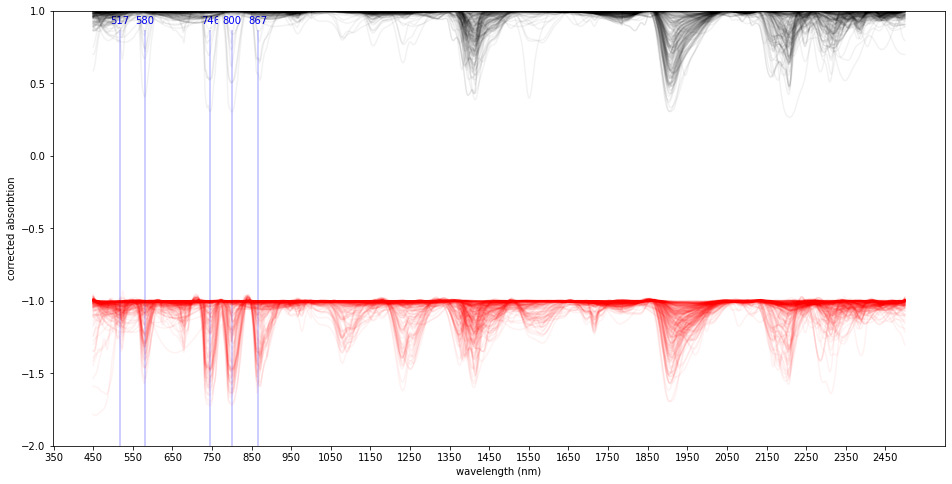

In [5]:
colour_idx = {0:'black', 1:'green', 2:'red'}
critical_wvs = [517.0, 580.0, 746.0, 800.0, 867.0]
wvl = df.columns[2:].values.astype('float')
start_wvl = 100 # start at 450
ncrs_stack = []

plt.figure(figsize=(16, 8))
for i, row in df.iloc[:,:].iterrows():
    class_idx = int(row['cm_ree_labels'])
    row = df.iloc[i,2:]
    # this spectrum seems to take a long time
    chq = SpectrumConvexHullQuotient(list(row[start_wvl:]), wvl=list(wvl[start_wvl:]))
    crs = chq.get_continuum_removed_spectrum()
    ncrs = (1 - (crs / np.amax(crs))) # normalized
    
    y = row[start_wvl:].values.astype(float)
    als_corr = y / sp.baseline_als(y, lam=1e5, p=0.99)
    plt.plot(wvl[start_wvl:], als_corr - 1.0 * class_idx, c=colour_idx[class_idx], alpha=0.05, zorder=1000)
    ncrs_stack.append(als_corr)
_ = plt.xticks(np.arange(wvl.min(), wvl.max(), 100))

for keyline in critical_wvs:
    plt.axvline(keyline, c='b', alpha=0.25)
    plt.text(keyline, 0.90, s=str(int(keyline)), ha='center', va='bottom', color='b', 
            bbox={'facecolor':'white', 'edgecolor':'white'})
    
plt.xlabel('wavelength (nm)')
plt.ylabel('corrected absorbtion')
_ =plt.ylim(-2.0, 1.0)

ncrs_stack = np.array(ncrs_stack)

# Select a subset of the wavelengths in the spectra

In [6]:
ree_wvl_range = slice(100, 650, 5)  # 450 - 999 nm
X = ncrs_stack[:, ree_wvl_range] # features
y = df['cm_ree_labels'].values
print(X.shape, y.shape)

(440, 110) (440,)


# Do min / max scaler within the 450 to 900 nm range

In [7]:
def min_max_scaler(arr):
    scaler = MinMaxScaler()
    return scaler.fit_transform(arr.reshape(-1, 1))

Xmm = np.apply_along_axis(min_max_scaler, axis=1, arr=X)[..., 0]
Xmm.shape

(440, 110)

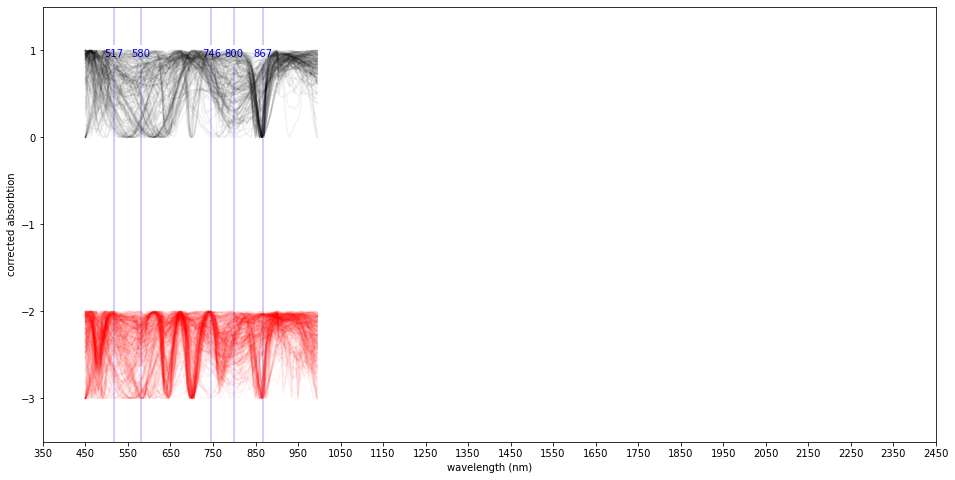

In [8]:
plt.figure(figsize=(16, 8))
for i, row in enumerate(Xmm):
    class_idx = int(df['cm_ree_labels'].iloc[i])
    plt.plot(wvl[ree_wvl_range], row - 1.5 * class_idx, c=colour_idx[class_idx], alpha=0.05, zorder=1000)
_ = plt.xticks(np.arange(wvl.min(), wvl.max(), 100))

for keyline in critical_wvs:
    plt.axvline(keyline, c='b', alpha=0.25)
    plt.text(keyline, 0.90, s=str(int(keyline)), ha='center', va='bottom', color='b', 
            bbox={'facecolor':'white', 'edgecolor':'white'})
    
plt.xlabel('wavelength (nm)')
plt.ylabel('corrected absorbtion')
_ =plt.ylim(-3.5, 1.5)
#_ =plt.xlim(min(wvl[ree_wvl_range]), max(wvl[ree_wvl_range]))

#ncrs_stack = np.array(ncrs_stack)

In [9]:
@interact
def quick_sig_plot(n=(1, len(df))):
    

    plt.figure()
    for i, s in enumerate(ncrs_stack[:, ree_wvl_range]):
        class_idx = int(df['cm_ree_labels'].iloc[i])
        plt.plot(min_max_scaler(s.reshape(-1, 1)),  c=colour_idx[class_idx], alpha=0.02)
    
    class_idx = int(df['cm_ree_labels'].iloc[n])
    sig = ncrs_stack[n, ree_wvl_range]
    plt.plot(sig, c=colour_idx[class_idx], linestyle='dotted',)
    plt.plot(min_max_scaler(sig.reshape(-1, 1)),  c=colour_idx[class_idx])
    plt.ylim(-0.1,1.1)
    
    

interactive(children=(IntSlider(value=220, description='n', max=440, min=1), Output()), _dom_classes=('widget-…

# Recasting X as Xmm

In [10]:
X = Xmm

In [11]:
y = df['cm_ree_labels']
y.shape, X.shape

((440,), (440, 110))

In [12]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

clf.fit(X, y)

print(clf.score(X, y))

0.7636363636363637


In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=15, min_samples_leaf=3)

clf.fit(X, y)

print(clf.score(X, y))

0.8159090909090909


# Get the N most import features

In [14]:
N = 10
imp = clf.feature_importances_
sorted_index_array = np.argsort(imp)[::-1]  # sort largest to smallest
import_wvls = wvl[ree_wvl_range][sorted_index_array][:N]
import_wvls

array([710., 855., 705., 865., 850., 845., 860., 700., 840., 720.])

In [15]:
def plot_important_feats(N=2, alpha=1.0):
    imp = clf.feature_importances_
    sorted_index_array = np.argsort(imp)[::-1][:N]  # sort largest to smallest
    import_wvls = wvl[ree_wvl_range][sorted_index_array]
    #print(sorted_index_array)
    #print(import_wvls)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    for i, row in enumerate(Xmm):
        class_idx = int(df['cm_ree_labels'].iloc[i])
        ax.plot(wvl[ree_wvl_range], row - 1.5 * class_idx, c=colour_idx[class_idx], alpha=0.05, zorder=1000)
    _ = ax.set_xticks(np.arange(wvl.min(), wvl.max(), 100))

    # feature importance annotation
    cmap = 'plasma'
    viridis = plt.get_cmap(cmap) 
    cnorm = colors.Normalize(vmin=0, vmax=1)
    scalarMap = cm.ScalarMappable(cmap=viridis, norm=cnorm)
    cvalues = np.linspace(1, 0.1, len(import_wvls))
    
    for impwvl, c in zip(import_wvls, cvalues):
        colorVal = scalarMap.to_rgba(c)
        im = ax.axvline(impwvl, alpha=alpha,
                    color=colorVal, lw=2
                    )

    ax.set_xlabel('wavelength (nm)')
    ax.set_ylabel('corrected absorbtion')

    # Create the inset axes and use it for the colorbar.
    cax = fig.add_axes([0.4, 0.25, 0.33, 0.33])
    im = cax.imshow(np.repeat(cvalues.reshape(-1,1), 1, axis=0), origin="lower", cmap=cmap, aspect=40, 
                   vmin=np.amin(cvalues), vmax=1.0)
    cax.set_title('Feature \n importance', size=10)
    #cax.set_ylim(np.amin(cvalues), 1.0)
    cbar = fig.colorbar(im, cax=cax, cmap=cmap, )
    
    _ = ax.set_ylim(-3.5, 1.5)

In [16]:
@interact
def important(N=(1, 100)):
    ind = np.argpartition(imp, -N)[-N:][::-1]
    import_wvls = wvl[ree_wvl_range][ind]
    #print(ind)
    print(import_wvls)

interactive(children=(IntSlider(value=50, description='N', min=1), Output()), _dom_classes=('widget-interact',…

In [17]:
import ipywidgets as ip

ip.interact(plot_important_feats, N=(1, 100, 1), alpha=(0.1, 1.0, 0.1))

interactive(children=(IntSlider(value=2, description='N', min=1), FloatSlider(value=1.0, description='alpha', …

<function __main__.plot_important_feats(N=2, alpha=1.0)>

# Split the data set 

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=40)

In [19]:
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.6409090909090909


In general, you need three datasets for training and evaulating models:

* Train — For fitting a candidate model.
* Val — For comparing different hyperparameter choices (model selection).
* Test — For seeing how well the final model generalizes.

Be careful; people give these different names sometimes. And people do different things with respect to comparing different algorithms — should we re-use the Val dataset, or use Test? If we use Test, are we possibly overfitting to that...

Anyway, we at least need to split the validation set into two parts: one to validate against while selecting hyperparameters (sometimes also called the dev set), and one to assess the likely real-world performance of the trained model.

Note that you should only predict on the test set once, at the end of model selection and tuning.

In [20]:
X_train, X_, y_train, y_ = train_test_split(Xmm, y, test_size=0.4, random_state=99)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=99)


The IID assumption
IID stands for independent and identically distributed, and most machine learning algorithms implicitly assume your data are IID. To put it another way: our samples are random

** We assume the IID assumption is valid so we can split randomly

# Dummy classifier

The dummy classifier tries to answer the question, "How well can I do with zero intelligence?". In other words, given the relative proportions of facies, what would you expect from random weighted guesses?

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy = DummyClassifier()

dummy.fit(X_train, y_train)

print(classification_report(y_train, dummy.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           2       0.62      1.00      0.76       163

    accuracy                           0.62       264
   macro avg       0.31      0.50      0.38       264
weighted avg       0.38      0.62      0.47       264



/home/evan/miniconda3/envs/reflectance/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/evan/miniconda3/envs/reflectance/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/evan/miniconda3/envs/reflectance/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [22]:
from sklearn.svm import SVC

model = SVC(C=1.5)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.625

[  1.00002303   1.09856592   1.20681929   1.32574002   1.45637927
   1.5998918    1.75754614   1.93073583   2.12099175   2.32999561
   2.55959483   2.81181891   3.0888973    3.39327918   3.72765503
   4.09498049   4.49850243   4.94178767   5.42875452   5.96370739
   6.55137485   7.19695142   7.90614352   8.68521985   9.54106685
  10.48124955  11.51407844  12.64868293  13.89509206  15.26432313
  16.76847908  18.4208555   20.23605813  22.23013197  24.42070308
  26.82713444  29.47069706  32.37475799  35.5649869   39.06958296
  42.91952412  47.14884088  51.79491717  56.89882072  62.50566611
  68.66501357  75.43130697  82.86435516  91.02986058 100.        ]


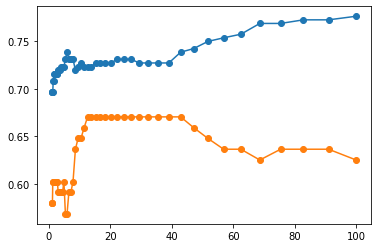

In [23]:
Cs = np.logspace(0.00001, 2, 50)
print(Cs)
y_train_sc = []
y_val_sc = []
for c in Cs:
    model = SVC(C=c, gamma= 1 / 200)
    model.fit(X_train, y_train)
    y_train_sc.append(model.score(X_train, y_train))
    y_val_sc.append(model.score(X_val, y_val))

plt.plot(Cs, y_train_sc, '-o')
plt.plot(Cs, y_val_sc, '-o')

In [24]:
Cs[np.argmax(y_val_sc)]

12.648682931695983

In [25]:
C_best = Cs[np.argmax(y_val_sc)]

In [26]:
model = SVC(C=C_best, gamma= 1 / 200)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.6704545454545454

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_val, model.predict(X_val), digits=3, ))

              precision    recall  f1-score   support

           0      0.625     0.641     0.633        39
           2      0.708     0.694     0.701        49

    accuracy                          0.670        88
   macro avg      0.667     0.667     0.667        88
weighted avg      0.671     0.670     0.671        88



In [28]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(y_true, y_pred, normalized=True):
    """
    The sklearn version of this function does not
    allow you to pass in a cross_validation result.
    """
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    if normalized:
        norm = (cnf_matrix.T / np.sum(cnf_matrix, axis=1)).T
    else:
        norm = cnf_matrix
    classes = np.unique(y_true)

    # Plot non-normalized confusion matrix.
    plt.figure(figsize=(6, 6))
    plt.imshow(norm, interpolation='nearest', cmap='Greens', vmin=0, vmax=1)
    plt.title("Confusion matrix")
    plt.colorbar(shrink=0.67)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Print the support numbers inside the plot.
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.ylim(2.5, -0.5)  # Bug in mpl.
    plt.tight_layout()
    plt.show()

    return


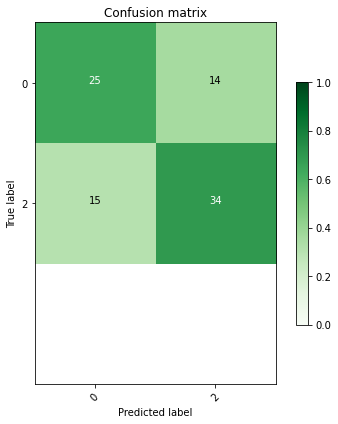

In [29]:
plot_confusion_matrix(y_val, model.predict(X_val))

### VIS

## Correct classficiations

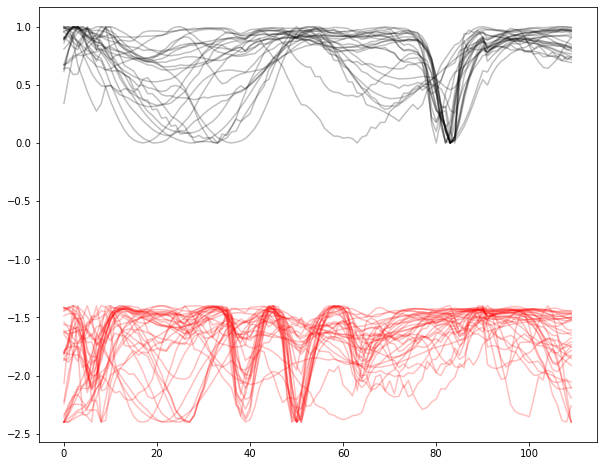

In [30]:
colour_idx = {0:'black', 1:'green', 2:'red'}
right = y_val == model.predict(X_val)
plt.figure(figsize=(10,8))

for sample, label in zip(X_val[right], y_val[right]):
    plt.plot(sample - 1.2 * label, c=colour_idx[label], alpha=0.25, zorder=1000)

## incorrect classficiations

In [31]:
colour_idx = {0:'black', 1:'green', 2:'red'}
right = y_val == model.predict(X_val)
y_pred = model.predict(X_val)


@interact
def incorrect_plot(n_val=(1, len(X_val)-1)):
    plt.figure(figsize=(10,8))
    for i, (sample, label, pred) in enumerate(zip(X_val, y_val, y_pred)):
        if label != pred:
            plt.plot(sample - 1.2 * label, c=colour_idx[pred], alpha=0.2, zorder=1000)
    #plt.plot(X_val[n_val, :] - 1.2 * y_val.values[n_val], c=colour_idx[y_val.values[n_val]], alpha=.9, zorder=1000)
    #print(y_val.index[n_val])

interactive(children=(IntSlider(value=44, description='n_val', max=87, min=1), Output()), _dom_classes=('widge…

# Probabilitistic predictions

In [32]:
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline

In [33]:
m = make_pipeline(SVC(probability=True))

y_prob = cross_val_predict(m, X_train, y_train,
                           method='predict_proba')

np.set_printoptions(precision=4)
y_prob[:5]

array([[0.3928, 0.6072],
       [0.4502, 0.5498],
       [0.4944, 0.5056],
       [0.6638, 0.3362],
       [0.2646, 0.7354]])